In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense
import numpy as np

In [2]:
df = pd.read_csv(r'C:\Users\pinkpigma\pinkpigma的同步盘\KDD研二上\可解释性框架-工作\数据\patient_diagnoses2000_ndc300_delete1.csv',)


In [37]:
#输入少了一个体重
x = df.iloc[:,3:3+71+2000]
y = df.iloc[:,3+71+2000:]
# print(x)
from sklearn.impute import SimpleImputer

from sklearn. preprocessing import LabelEncoder 
x['gender'] = LabelEncoder().fit_transform(x['gender'])
x['ethnicity'] = LabelEncoder().fit_transform(x['ethnicity'])
x['ethnicity_grouped'] = LabelEncoder().fit_transform(x['ethnicity_grouped'])
x['first_hosp_stay'] = LabelEncoder().fit_transform(x['first_hosp_stay'])

imp = SimpleImputer(missing_values=np.nan, strategy='mean')

x = imp.fit_transform(x)




       heartrate_min  heartrate_max  heartrate_mean  sysbp_min  sysbp_max  \
0               89.0          142.0      107.085714       95.0      165.0   
1               60.0           97.0       81.588235       77.0      153.0   
2               51.0           79.0       65.333333       98.0      133.0   
3               29.0           52.0       34.844828       93.0      165.0   
4               78.0          118.0       93.260870      125.0      178.0   
...              ...            ...             ...        ...        ...   
38319           58.0           82.0       65.473684      129.0      188.0   
38320           81.0          113.0       94.000000      100.0      134.0   
38321           67.0          107.0       85.250000       61.0      157.0   
38322           65.0           86.0       71.120000       92.0      130.0   
38323           66.0           96.0       81.185185      143.0      187.0   

       sysbp_mean  diasbp_min  diasbp_max  diasbp_mean  meanbp_min  ...  05

In [4]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
from keras import backend as K
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

# y_train

In [24]:
from keras import backend as K
from keras import losses
import numpy as np
import tensorflow as tf
from keras import losses
def Jaccard_Loss(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    y_true_expand = K.expand_dims(y_true, axis=0)
    y_pred_expand = K.expand_dims(y_pred, axis=-1)

    fenzi = K.dot(y_true_expand, y_pred_expand)

    fenmu_1 = K.sum(y_true, keepdims=True)

    fenmu_2 = K.ones_like(y_true_expand) - y_true_expand
    fenmu_2 = K.dot(fenmu_2, y_pred_expand)

    return K.mean((tf.constant([[1]], dtype=tf.float32) - (fenzi / (fenmu_1 + fenmu_2))), axis=-1)




def JI(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
#     K.print_tensor(y_true, message='y_true = ')

    threshold_value = 0.3

    y_pred = K.cast(K.greater(y_pred, threshold_value), K.floatx())
#     K.print_tensor(y_pred, message='y_pred = ')
    fenzi = K.sum(y_true * y_pred, keepdims=True)
    # true_positives_sum = K.sum(true_positives, keepdims=True)
    fenmu = K.sum(K.cast((K.greater(y_true + y_pred, 0.8)), K.floatx()), keepdims=True)

    return K.mean(fenzi / fenmu, axis=-1)



def deep_model(feature_dim,label_dim, layer_num=1):
    from keras.models import Sequential
    from keras.layers import Dense
    model = Sequential()
    print("create model. feature_dim ={}, label_dim ={}".format(feature_dim, label_dim))
    model.add(Dense(512, activation='relu', input_dim=feature_dim))
    
    for i in range(layer_num):
        model.add(Dense(512, activation='relu'))
    model.add(Dense(label_dim, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[JI])
    return model

In [31]:
import keras
callbacks_list = [
    # This callback will interrupt training when we have stopped improving
     keras.callbacks.EarlyStopping(
    # This callback will monitor the validation accuracy of the model
    monitor='val_loss',
     # Training will be interrupted when the accuracy
     # has stopped improving for *more* than 1 epochs (i.e. 2 epochs)
     patience=20,
    ),
#     keras.callbacks.ReduceLROnPlateau(
#      # This callback will monitor the validation loss of the model
#      monitor='val_loss',
#      # It will divide the learning by 10 when it gets triggered
#      factor=0.1,
#      # It will get triggered after the validation loss has stopped improving
#      # for at least 10 epochs
#      patience=10,
#     ),
    # This callback will save the current weights after every epoch
    keras.callbacks.ModelCheckpoint(
     filepath=r'C:\Users\pinkpigma\pinkpigma的同步盘\KDD研二上\jupyter\model\my_model.h5', # Path to the destination model file
     # The two arguments below mean that we will not overwrite the
    # model file unless `val_loss` has improved, which
    # allows us to keep the best model every seen during training.
    monitor='val_loss',
    save_best_only=True,
    )
]


In [22]:
import matplotlib.pyplot as plt
def train_deep(X_train,y_train,X_test,y_test, layer_num=1, callbacks_list = []):
    feature_dim = X_train.shape[1]
    label_dim = y_train.shape[1]
    model = deep_model(feature_dim,label_dim, layer_num)
    model.summary()
    history = model.fit(X_train,y_train,batch_size=256, epochs=1000,callbacks=callbacks_list,validation_data=(X_test,y_test), verbose=1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()



create model. feature_dim =2071, label_dim =300
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 512)               1060864   
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 dense_18 (Dense)            (None, 300)               153900    
                                                                 
Total params: 1,477,420
Trainable params: 1,477,420
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
120/120 [==============================] - 2s 14ms/step - loss: 0.4602 - JI: 0.0335 - val_loss: 0.1181 - val_JI: 0.0262
Epoch 2/1000
120/120 [==============================] - 2s 13ms/step - loss: 0.1256 - JI: 0.0316 - val_loss: 0.1226 - val_JI: 0

Epoch 56/1000
120/120 [==============================] - 2s 13ms/step - loss: 0.0886 - JI: 0.1445 - val_loss: 0.0928 - val_JI: 0.1415
Epoch 57/1000
120/120 [==============================] - 2s 13ms/step - loss: 0.0884 - JI: 0.1456 - val_loss: 0.0932 - val_JI: 0.1260
Epoch 58/1000
120/120 [==============================] - 2s 13ms/step - loss: 0.0881 - JI: 0.1482 - val_loss: 0.0931 - val_JI: 0.1185
Epoch 59/1000
120/120 [==============================] - 2s 13ms/step - loss: 0.0911 - JI: 0.1300 - val_loss: 0.0937 - val_JI: 0.1215
Epoch 60/1000
120/120 [==============================] - 2s 13ms/step - loss: 0.0887 - JI: 0.1428 - val_loss: 0.0943 - val_JI: 0.1319
Epoch 61/1000
120/120 [==============================] - 2s 13ms/step - loss: 0.0885 - JI: 0.1452 - val_loss: 0.0934 - val_JI: 0.1256
Epoch 62/1000
120/120 [==============================] - 2s 15ms/step - loss: 0.0879 - JI: 0.1487 - val_loss: 0.0929 - val_JI: 0.1450
Epoch 63/1000
120/120 [==============================] - 2s 13

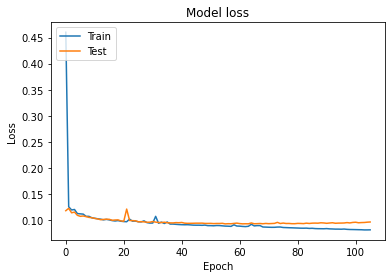

In [16]:
train_deep(X_train,y_train,X_test,y_test,1, callbacks_list)

In [12]:
train_deep(X_train,y_train,X_test,y_test,2)

create model. feature_dim =2071, label_dim =300
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               1060864   
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 300)               153900    
                                                                 
Total params: 1,740,076
Trainable params: 1,740,076
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
120/120 [==============================] - 3s 18ms/step - loss: 0.2716 - JI: 0.0239 - val_loss: 0.1131 - val_JI: 0.

Epoch 55/1000
120/120 [==============================] - 2s 17ms/step - loss: 0.0857 - JI: 0.1661 - val_loss: 0.0934 - val_JI: 0.1416
Epoch 56/1000
120/120 [==============================] - 2s 17ms/step - loss: 0.0851 - JI: 0.1717 - val_loss: 0.0940 - val_JI: 0.1147
Epoch 57/1000
120/120 [==============================] - 2s 17ms/step - loss: 0.0854 - JI: 0.1697 - val_loss: 0.0947 - val_JI: 0.1320
Epoch 58/1000
120/120 [==============================] - 2s 16ms/step - loss: 0.0847 - JI: 0.1734 - val_loss: 0.0970 - val_JI: 0.1182
Epoch 59/1000
120/120 [==============================] - 2s 15ms/step - loss: 0.0852 - JI: 0.1722 - val_loss: 0.0956 - val_JI: 0.1321
Epoch 60/1000
120/120 [==============================] - 2s 16ms/step - loss: 0.0845 - JI: 0.1760 - val_loss: 0.0939 - val_JI: 0.1266
Epoch 61/1000
120/120 [==============================] - 2s 15ms/step - loss: 0.0841 - JI: 0.1801 - val_loss: 0.0962 - val_JI: 0.1278
Epoch 62/1000
120/120 [==============================] - 2s 16

120/120 [==============================] - 2s 15ms/step - loss: 0.0717 - JI: 0.2904 - val_loss: 0.1116 - val_JI: 0.1349
Epoch 117/1000
120/120 [==============================] - 2s 16ms/step - loss: 0.0702 - JI: 0.2909 - val_loss: 0.1122 - val_JI: 0.1401
Epoch 118/1000
120/120 [==============================] - 2s 15ms/step - loss: 0.0708 - JI: 0.2948 - val_loss: 0.1128 - val_JI: 0.1364
Epoch 119/1000
120/120 [==============================] - 2s 15ms/step - loss: 0.0697 - JI: 0.2954 - val_loss: 0.1151 - val_JI: 0.1273
Epoch 120/1000
120/120 [==============================] - 2s 15ms/step - loss: 0.0710 - JI: 0.2859 - val_loss: 0.1143 - val_JI: 0.1371
Epoch 121/1000
120/120 [==============================] - 2s 15ms/step - loss: 0.0696 - JI: 0.2966 - val_loss: 0.1152 - val_JI: 0.1356
Epoch 122/1000
120/120 [==============================] - 2s 15ms/step - loss: 0.0721 - JI: 0.2835 - val_loss: 0.1127 - val_JI: 0.1437
Epoch 123/1000
120/120 [==============================] - 2s 15ms/step

Epoch 177/1000
120/120 [==============================] - 2s 16ms/step - loss: 0.0614 - JI: 0.3622 - val_loss: 0.1469 - val_JI: 0.1262
Epoch 178/1000
120/120 [==============================] - 2s 15ms/step - loss: 0.0595 - JI: 0.3767 - val_loss: 0.1514 - val_JI: 0.1364
Epoch 179/1000
120/120 [==============================] - 2s 15ms/step - loss: 0.0588 - JI: 0.3835 - val_loss: 0.1520 - val_JI: 0.1364
Epoch 180/1000
120/120 [==============================] - 2s 16ms/step - loss: 0.0583 - JI: 0.3873 - val_loss: 0.1551 - val_JI: 0.1283
Epoch 181/1000
120/120 [==============================] - 2s 16ms/step - loss: 0.0579 - JI: 0.3899 - val_loss: 0.1552 - val_JI: 0.1273
Epoch 182/1000
120/120 [==============================] - 2s 16ms/step - loss: 0.0580 - JI: 0.3897 - val_loss: 0.1555 - val_JI: 0.1308
Epoch 183/1000
120/120 [==============================] - 2s 16ms/step - loss: 0.0579 - JI: 0.3905 - val_loss: 0.1566 - val_JI: 0.1319
Epoch 184/1000
120/120 [==============================]

KeyboardInterrupt: 

In [13]:
train_deep(X_train,y_train,X_test,y_test,3, callbacks_list)

create model. feature_dim =2071, label_dim =300
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 512)               1060864   
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dense_12 (Dense)            (None, 300)               153900    
                                                                 
Total params: 2,002,732
Trainable params: 2,002,732
Non-trainable params: 0
______________________________________________________________

Epoch 54/1000
120/120 [==============================] - 2s 18ms/step - loss: 0.0885 - JI: 0.1440 - val_loss: 0.0944 - val_JI: 0.1203
Epoch 55/1000
120/120 [==============================] - 2s 19ms/step - loss: 0.0883 - JI: 0.1461 - val_loss: 0.0936 - val_JI: 0.1194
Epoch 56/1000
120/120 [==============================] - 2s 19ms/step - loss: 0.0879 - JI: 0.1481 - val_loss: 0.0926 - val_JI: 0.1206
Epoch 57/1000
120/120 [==============================] - 2s 20ms/step - loss: 0.0880 - JI: 0.1479 - val_loss: 0.0931 - val_JI: 0.1290
Epoch 58/1000
120/120 [==============================] - 2s 19ms/step - loss: 0.0878 - JI: 0.1506 - val_loss: 0.0930 - val_JI: 0.1351
Epoch 59/1000
120/120 [==============================] - 2s 18ms/step - loss: 0.0873 - JI: 0.1534 - val_loss: 0.0930 - val_JI: 0.1350
Epoch 60/1000
120/120 [==============================] - 2s 18ms/step - loss: 0.0879 - JI: 0.1523 - val_loss: 0.0940 - val_JI: 0.1346
Epoch 61/1000
120/120 [==============================] - 2s 19

create model. feature_dim =2071, label_dim =300
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 512)               1060864   
                                                                 
 dense_20 (Dense)            (None, 512)               262656    
                                                                 
 dense_21 (Dense)            (None, 512)               262656    
                                                                 
 dense_22 (Dense)            (None, 512)               262656    
                                                                 
 dense_23 (Dense)            (None, 512)               262656    
                                                                 
 dense_24 (Dense)            (None, 300)               153900    
                                                                 
Total 

Epoch 53/1000
120/120 [==============================] - 3s 21ms/step - loss: 0.0898 - JI: 0.1390 - val_loss: 0.0931 - val_JI: 0.1246
Epoch 54/1000
120/120 [==============================] - 3s 21ms/step - loss: 0.0897 - JI: 0.1415 - val_loss: 0.0932 - val_JI: 0.1140
Epoch 55/1000
120/120 [==============================] - 3s 21ms/step - loss: 0.0944 - JI: 0.1387 - val_loss: 0.0932 - val_JI: 0.1326
Epoch 56/1000
120/120 [==============================] - 3s 22ms/step - loss: 0.0907 - JI: 0.1367 - val_loss: 0.0948 - val_JI: 0.1175
Epoch 57/1000
120/120 [==============================] - 3s 23ms/step - loss: 0.0982 - JI: 0.1398 - val_loss: 0.0939 - val_JI: 0.1383
Epoch 58/1000
120/120 [==============================] - 3s 21ms/step - loss: 0.0893 - JI: 0.1382 - val_loss: 0.0956 - val_JI: 0.1219
Epoch 59/1000
120/120 [==============================] - 2s 21ms/step - loss: 0.0936 - JI: 0.1334 - val_loss: 0.0926 - val_JI: 0.1302
Epoch 60/1000
120/120 [==============================] - 3s 21

120/120 [==============================] - 3s 21ms/step - loss: 0.0795 - JI: 0.2134 - val_loss: 0.0978 - val_JI: 0.1424
Epoch 115/1000
120/120 [==============================] - 2s 21ms/step - loss: 0.0797 - JI: 0.2128 - val_loss: 0.0974 - val_JI: 0.1421
Epoch 116/1000
120/120 [==============================] - 3s 21ms/step - loss: 0.0789 - JI: 0.2176 - val_loss: 0.0981 - val_JI: 0.1402
Epoch 117/1000
120/120 [==============================] - 2s 21ms/step - loss: 0.0780 - JI: 0.2231 - val_loss: 0.0987 - val_JI: 0.1420
Epoch 118/1000
120/120 [==============================] - 2s 21ms/step - loss: 0.0779 - JI: 0.2253 - val_loss: 0.0985 - val_JI: 0.1310
Epoch 119/1000
120/120 [==============================] - 3s 21ms/step - loss: 0.0776 - JI: 0.2267 - val_loss: 0.0994 - val_JI: 0.1417
Epoch 120/1000
120/120 [==============================] - 3s 21ms/step - loss: 0.0769 - JI: 0.2334 - val_loss: 0.0998 - val_JI: 0.1429
Epoch 121/1000
120/120 [==============================] - 2s 21ms/step

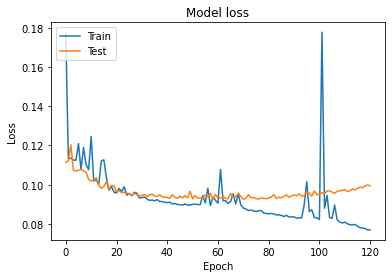

In [17]:
train_deep(X_train,y_train,X_test,y_test,4, callbacks_list)

In [25]:
from keras import regularizers
def deep_model_reg(feature_dim,label_dim, layer_num=1):
    from keras.models import Sequential
    from keras.layers import Dense
    model = Sequential()
    print("create model. feature_dim ={}, label_dim ={}".format(feature_dim, label_dim))
    model.add(Dense(512, activation='relu', input_dim=feature_dim))
    
    for i in range(layer_num):
        model.add(Dense(512, activation='relu',kernel_regularizer=regularizers.l1(0.01)))
    model.add(Dense(label_dim, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[JI])
    return model

In [26]:
import matplotlib.pyplot as plt
def train_deep_reg(X_train,y_train,X_test,y_test, layer_num=1, callbacks_list = []):
    feature_dim = X_train.shape[1]
    label_dim = y_train.shape[1]
    model = deep_model_reg(feature_dim,label_dim, layer_num)
    model.summary()
    history = model.fit(X_train,y_train,batch_size=256, epochs=1000,callbacks=callbacks_list,validation_data=(X_test,y_test), verbose=1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

create model. feature_dim =2071, label_dim =300
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_61 (Dense)            (None, 512)               1060864   
                                                                 
 dense_62 (Dense)            (None, 512)               262656    
                                                                 
 dense_63 (Dense)            (None, 300)               153900    
                                                                 
Total params: 1,477,420
Trainable params: 1,477,420
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
120/120 [==============================] - 2s 16ms/step - loss: 29.4558 - JI: 0.0284 - val_loss: 3.4383 - val_JI: 0.0148
Epoch 2/1000
120/120 [==============================] - 2s 14ms/step - loss: 1.2630 - JI: 0.0088 - val_loss: 0.4945 - val_JI:

Epoch 55/1000
120/120 [==============================] - 2s 15ms/step - loss: 0.3969 - JI: 0.0369 - val_loss: 0.3956 - val_JI: 0.0351
Epoch 56/1000
120/120 [==============================] - 2s 14ms/step - loss: 0.3964 - JI: 0.0371 - val_loss: 0.3978 - val_JI: 0.0371
Epoch 57/1000
120/120 [==============================] - 2s 14ms/step - loss: 0.3965 - JI: 0.0384 - val_loss: 0.3948 - val_JI: 0.0339
Epoch 58/1000
120/120 [==============================] - 2s 14ms/step - loss: 0.3967 - JI: 0.0382 - val_loss: 0.3950 - val_JI: 0.0395
Epoch 59/1000
120/120 [==============================] - 2s 14ms/step - loss: 0.3962 - JI: 0.0392 - val_loss: 0.3961 - val_JI: 0.0391
Epoch 60/1000
120/120 [==============================] - 2s 14ms/step - loss: 0.3962 - JI: 0.0384 - val_loss: 0.3965 - val_JI: 0.0367
Epoch 61/1000
120/120 [==============================] - 2s 14ms/step - loss: 0.3960 - JI: 0.0395 - val_loss: 0.3950 - val_JI: 0.0442
Epoch 62/1000
120/120 [==============================] - 2s 14

120/120 [==============================] - 2s 15ms/step - loss: 0.3926 - JI: 0.0528 - val_loss: 0.3922 - val_JI: 0.0530
Epoch 117/1000
120/120 [==============================] - 2s 14ms/step - loss: 0.3923 - JI: 0.0531 - val_loss: 0.3914 - val_JI: 0.0553
Epoch 118/1000
120/120 [==============================] - 2s 18ms/step - loss: 0.3923 - JI: 0.0540 - val_loss: 0.3926 - val_JI: 0.0472
Epoch 119/1000
120/120 [==============================] - 2s 14ms/step - loss: 0.3922 - JI: 0.0537 - val_loss: 0.3923 - val_JI: 0.0548
Epoch 120/1000
120/120 [==============================] - 2s 14ms/step - loss: 0.3921 - JI: 0.0540 - val_loss: 0.3919 - val_JI: 0.0575
Epoch 121/1000
120/120 [==============================] - 2s 15ms/step - loss: 0.3922 - JI: 0.0545 - val_loss: 0.3923 - val_JI: 0.0538
Epoch 122/1000
120/120 [==============================] - 2s 15ms/step - loss: 0.3951 - JI: 0.0549 - val_loss: 0.3929 - val_JI: 0.0514
Epoch 123/1000
120/120 [==============================] - 2s 14ms/step

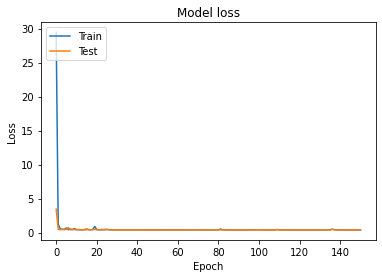

In [32]:
train_deep_reg(X_train,y_train,X_test,y_test,1, callbacks_list)

create model. feature_dim =2071, label_dim =300
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 512)               1060864   
                                                                 
 dense_65 (Dense)            (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_66 (Dense)            (None, 300)               153900    
                                                                 
Total params: 1,477,420
Trainable params: 1,477,420
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
120/120 [==============================] - 3s 17ms/step - loss: 0.6069 - JI: 0.0354 - val_loss: 0.1228 - val_JI: 0

120/120 [==============================] - 2s 17ms/step - loss: 0.0946 - JI: 0.1055 - val_loss: 0.0948 - val_JI: 0.0959
Epoch 116/1000
120/120 [==============================] - 2s 15ms/step - loss: 0.0929 - JI: 0.1102 - val_loss: 0.0947 - val_JI: 0.0954
Epoch 117/1000
120/120 [==============================] - 2s 15ms/step - loss: 0.0930 - JI: 0.1117 - val_loss: 0.0938 - val_JI: 0.1051
Epoch 118/1000
120/120 [==============================] - 2s 15ms/step - loss: 0.0930 - JI: 0.1118 - val_loss: 0.0966 - val_JI: 0.0830
Epoch 119/1000
120/120 [==============================] - 2s 15ms/step - loss: 0.0931 - JI: 0.1082 - val_loss: 0.0938 - val_JI: 0.1047
Epoch 120/1000
120/120 [==============================] - 2s 15ms/step - loss: 0.0934 - JI: 0.1082 - val_loss: 0.0940 - val_JI: 0.0987
Epoch 121/1000
120/120 [==============================] - 2s 15ms/step - loss: 0.0948 - JI: 0.1065 - val_loss: 0.0957 - val_JI: 0.0947
Epoch 122/1000
120/120 [==============================] - 2s 15ms/step

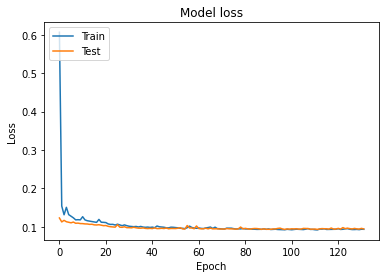

In [33]:
from keras.layers import Dropout
def deep_model_dropout(feature_dim,label_dim, layer_num=1):
    from keras.models import Sequential
    from keras.layers import Dense
    model = Sequential()
    print("create model. feature_dim ={}, label_dim ={}".format(feature_dim, label_dim))
    model.add(Dense(512, activation='relu', input_dim=feature_dim))
    
    for i in range(layer_num):
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
    model.add(Dense(label_dim, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[JI])
    return model
import matplotlib.pyplot as plt
def train_deep_dropout(X_train,y_train,X_test,y_test, layer_num=1, callbacks_list = []):
    feature_dim = X_train.shape[1]
    label_dim = y_train.shape[1]
    model = deep_model_dropout(feature_dim,label_dim, layer_num)
    model.summary()
    history = model.fit(X_train,y_train,batch_size=256, epochs=1000,callbacks=callbacks_list,validation_data=(X_test,y_test), verbose=1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
train_deep_dropout(X_train,y_train,X_test,y_test,1, callbacks_list)

In [34]:
train_deep_dropout(X_train,y_train,X_test,y_test,3, callbacks_list)

create model. feature_dim =2071, label_dim =300
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_67 (Dense)            (None, 512)               1060864   
                                                                 
 dense_68 (Dense)            (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_69 (Dense)            (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_70 (Dense)            (None, 512)               262656    
                                                                 
 drop

KeyboardInterrupt: 